In [1]:
import botorch
from known_boundary.acquisition_function import EI_acquisition_opt,SLogTEI_acquisition_opt,SLogEI_acquisition_opt
from known_boundary.utlis import  get_initial_points,transform,opt_model_MLE
import numpy as np
import GPy
import torch
from botorch.test_functions import Ackley,Levy,Beale,Branin,Hartmann,Rosenbrock,Powell,SixHumpCamel
from botorch.utils.transforms import unnormalize,normalize
from known_boundary.SLogGP import SLogGP
import scipy 

import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('lengthscale').disabled = True
logging.getLogger('variance').disabled = True
logging.getLogger('psi').disabled = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double



/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
lengthscale_range = [0.01,1]
variance_range = [0.01**2,10]
noise = 1e-6

In [4]:
fun = Branin(negate=False)

dim = fun.dim
bounds = fun.bounds
standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)

if dim <=3:
    step_size = 2
elif dim<=7:
    step_size = 3
else:
    step_size = 4
    
n_init = 4*dim
iter_num = 50
N = 20

fstar = 0.397887


# EI

In [47]:
BO_EI = []

for exp in range(N):
    
    print(exp)
    
    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    best_record = [Y_BO.min().item()]
    np.random.seed(1234)

    for i in range(iter_num):

            print(i)
        
            train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
            train_X = normalize(X_BO, bounds)
            
            minimal = train_Y.min().item()
            
            train_Y = train_Y.numpy()
            train_X = train_X.numpy()
            
            # train the GP
            if i%step_size == 0:
                
                parameters = opt_model(train_X,train_Y,dim,'GP',noise=noise,lengthscale_range=lengthscale_range,variance_range=variance_range)
                    
                lengthscale = parameters[0]
                variance = parameters[1]
                
                print('lengthscale: ',lengthscale)
                print('variance: ',variance)
                
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale=lengthscale,variance=variance)
            m = GPy.models.GPRegression(train_X.reshape(-1,dim), train_Y.reshape(-1,1),kernel)
            m.Gaussian_noise.fix(noise)
            
            standard_next_X = EI_acquisition_opt(m,bounds=standard_bounds,f_best=minimal)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            
            print(best_record[-1])
            
    best_record = np.array(best_record) 
    BO_EI.append(best_record)

0
0
lengthscale:  0.17623202369663254
variance:  0.8980387386167417
13.359805351914142
1
11.523894930839917
2
lengthscale:  0.14878474171998055
variance:  0.697705431397292
7.518001820627228
3
7.518001820627228
4
lengthscale:  0.07779595780400914
variance:  0.7108140509914342
0.1325230722002364
5
0.1325230722002364
6
lengthscale:  0.03716588283288932
variance:  0.7232713688329975
0.1325230722002364
7
0.1325230722002364
8
lengthscale:  0.02664027512304116
variance:  0.6333169936071182
0.1325230722002364
9
0.1325230722002364
10
lengthscale:  0.026399475828304347
variance:  0.6333356453728147
0.1325230722002364
11
0.1325230722002364
12
lengthscale:  0.026247725183146553
variance:  0.6438789248518404
0.1325230722002364
13
0.1325230722002364
14
lengthscale:  0.02608663795586743
variance:  0.6448491462994408
0.1325230722002364
15
0.1325230722002364
16
lengthscale:  0.021393636330011907
variance:  0.6901425470767291
0.1325230722002364
17
0.1325230722002364
18
lengthscale:  0.01407739604403832

# SLogEI (set C=1)

In [11]:
SLogEI_C1 = []

for exp in range(N):

    seed = exp
    
    print(exp)

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)



    best_record = [Y_BO.min().item()]
    np.random.seed(1234)

    for i in range(iter_num):

            print('inner loop: ',i)
        
            train_Y = Y_BO.numpy()
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            lower = 1.
            upper = 1.+10**(-6)
            
            c_range = [lower,upper]

            if i%step_size == 0:
                
                parameters = opt_model(train_X,train_Y,dim,'SLogGP',noise=noise,lengthscale_range=lengthscale_range,variance_range=variance_range,c_range=c_range)                
    
                lengthscale = parameters[0]
                variance = parameters[1]
                c = parameters[2]
            
                print('lengthscale is ',lengthscale)
                print('variance is ',variance)
                print('c is ',c)
            
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
            
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(1e-5)
            
            standard_next_X = SLogEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print(best_record[-1])
            
    best_record = np.array(best_record)         
    SLogEI_C1.append(best_record)

0
inner loop:  0
lengthscale is  0.2705963870109258
variance is  1.0356724213697501
c is  1.0000005497114448
3.5451968551073154
inner loop:  1
3.5451968551073154
inner loop:  2
lengthscale is  0.23721234573780203
variance is  0.5493967329301988
c is  1.0000009726844592
3.4509706608557575
inner loop:  3
1.2294115694407246
inner loop:  4
lengthscale is  0.12010327705632487
variance is  1.176252087208363
c is  1.0000009726852546
0.6651734822513191
inner loop:  5
0.6651734822513191
inner loop:  6
lengthscale is  0.12624123370210305
variance is  1.5869119728204029
c is  1.0000009726842536
0.6651734822513191
inner loop:  7
0.6651734822513191
inner loop:  8
lengthscale is  0.13400333584039456
variance is  1.6476222026780176
c is  1.0000009726843222
0.41922037554642166
inner loop:  9
0.41922037554642166
inner loop:  10
lengthscale is  0.14551632440048168
variance is  1.7425747451458273
c is  1.0000009726842962
0.41922037554642166
inner loop:  11
0.41922037554642166
inner loop:  12
lengthscale 

# SLogEI (no boundary)

In [5]:
SLogEI_noboundary = []

for exp in range(1):

    seed = 1
    
    print(exp)

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)



    best_record = [Y_BO.min().item()]
    np.random.seed(1234)

    for i in range(iter_num):

            #print('inner loop: ',i)
        
            train_Y = Y_BO.numpy()
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            train_Y_std = np.std(train_Y)
            lower = -np.min(train_Y)+10**(-6)
            upper = lower+min(300,5*train_Y_std)
            
            c_range = [lower,upper]

            if i%step_size == 0:
                
                parameters = opt_model_MLE(train_X,train_Y,dim,'SLogGP',noise=noise,lengthscale_range=lengthscale_range,variance_range=variance_range,c_range=c_range)                
    
                lengthscale = parameters[0]
                variance = parameters[1]
                c = parameters[2]
                
                print('lengthscale is ',lengthscale)
                print('variance is ',variance)
                print('c is ',c)
            
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
            
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(noise)
            
            standard_next_X = SLogEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print(best_record[-1])
            
    best_record = np.array(best_record)         
    SLogEI_noboundary.append(best_record)

0


LinAlgError: not positive definite, even with jitter.

In [4]:
from known_boundary.acquisition_function import SLogTEI,SLogEI

In [6]:
SLogEI_noboundary = []

for exp in range(1):

    seed = 1
    
    print(exp)

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)



    best_record = [Y_BO.min().item()]
    np.random.seed(1234)

    for i in range(iter_num):

            print('inner loop: ',i)
        
            train_Y = Y_BO.numpy()
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            train_Y_std = np.std(train_Y)
            lower = -np.min(train_Y)+10**(-6)
            upper = lower+min(300,5*train_Y_std)
            
            c_range = [lower,upper]

            if i%step_size == 0:
                
                parameters = opt_model(train_X,train_Y,dim,'SLogGP',noise=noise,lengthscale_range=lengthscale_range,variance_range=variance_range,c_range=c_range)                
    
                lengthscale = parameters[0]
                variance = parameters[1]
                c = parameters[2]
                
                print('lengthscale is ',lengthscale)
                print('variance is ',variance)
                print('c is ',c)
            
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
            
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(noise)
            
            if -c>fstar: # we do not truncate
                print('logEI!!')
                standard_next_X = SLogEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y)
            else:
                print('logTEI!!')
                standard_next_X = SLogTEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y,fstar=fstar)
            print(standard_next_X)
            # print('logTEI: ', SLogTEI(X=standard_next_X,dim=2,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y,fstar=fstar,model=m))
            # print('logEI: ', SLogEI(X=standard_next_X,dim=2,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y,model=m))
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print(best_record[-1])
            
    best_record = np.array(best_record)         
    SLogEI_noboundary.append(best_record)

0
inner loop:  0
lengthscale is  0.23746690152025693
variance is  15.999999819149702
c is  -9.746849357467708
logEI!!
[0.99287996 0.36638578]
logTEI:  [nan]
logEI:  [9.31220169e-08]
8.178266838212206
inner loop:  1
logEI!!
[0.04011985 0.03185386]
logTEI:  [nan]
logEI:  [nan]
8.178266838212206
inner loop:  2
lengthscale is  0.5367009331426089
variance is  2.2666274335525793
c is  19.950386817148512
logTEI!!
[0.98760623 0.16717943]
logTEI:  [7.68781143]
logEI:  [10.2183255]
1.2158262709689591
inner loop:  3
logTEI!!
[0.         0.60681019]
logTEI:  [0.6682698]
logEI:  [3.71976923]
1.2158262709689591
inner loop:  4
lengthscale is  0.22047231829443234
variance is  2.05979449376479
c is  0.9198521865670808
logTEI!!
[0.93139279 0.1101469 ]
logTEI:  [0.2165994]
logEI:  [0.22568505]
1.2158262709689591
inner loop:  5
logTEI!!
[1.         0.10518653]
logTEI:  [0.18733126]
logEI:  [0.18972673]
1.2158262709689591
inner loop:  6
lengthscale is  0.20024709303825544
variance is  1.3674470847662121
c 

In [8]:
m

GP_regression.,value,constraints,priors
rbf.variance,15.99999999999238,+ve,
rbf.lengthscale,0.2625562476309475,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


# SLogTEI (enforced boundary)

In [115]:
SLogEI_enforceboundary = []

for exp in range(N):

    seed = exp
    
    print(exp)

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)



    best_record = [Y_BO.min().item()]
    np.random.seed(1234)

    for i in range(iter_num):

            print('inner loop: ',i)
        
            train_Y = Y_BO.numpy()
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            lower = -fstar+10**(-6)
            upper = lower+0.3

            if i%step_size == 0:
                m = GPy.models.WarpedGP(train_X.reshape(-1,dim), train_Y.reshape(-1,1),warping_function=SLogGP(lower=lower,upper=upper,n_terms =1))
                m.rbf.lengthscale.constrain_bounded(0.01,2)
                m.rbf.variance.constrain_bounded(0.01**2,4**2)
                m.Gaussian_noise.fix(1e-5)
                
                parameter_num = 3           
                    
                for _ in range(3**parameter_num):
                    try:
                        np.random.seed(i)
                        m.optimize()
                    except:
                        print('pass')
                        pass
                
    
                lengthscale = m.rbf.lengthscale.item()
                variance = m.rbf.variance.item()
                c = m.SlogGP.psi.item()
            
                print('lengthscale is ',lengthscale)
                print('variance is ',variance)
                print('c is ',c)
            
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
            
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(1e-5)
            
            standard_next_X = SLogEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print(best_record[-1])
            
    best_record = np.array(best_record)         
    SLogEI_enforceboundary.append(best_record)

0
inner loop:  0
lengthscale is  0.1914574617014607
variance is  9.999917101542946
c is  0.0048213209405569765
41.541068023078196
inner loop:  1
30.06117217160515
inner loop:  2
lengthscale is  0.1451600842807204
variance is  9.448107024956721
c is  3.128903479162578e-05
30.06117217160515
inner loop:  3
30.06117217160515
inner loop:  4
lengthscale is  0.0480260422963715
variance is  9.999957720470077
c is  8.238386084693021e-05
30.06117217160515
inner loop:  5
1.7364309520793908
inner loop:  6
lengthscale is  0.04178679997138895
variance is  9.999995747920305
c is  0.29993068540703444
1.7364309520793908
inner loop:  7
1.7364309520793908
inner loop:  8
lengthscale is  0.019493161661158595
variance is  9.999998793167384
c is  2.2075997491730104e-06
1.7364309520793908
inner loop:  9
1.7364309520793908
inner loop:  10
lengthscale is  0.010000012706428023
variance is  9.999980423879858
c is  0.299994269263333
1.7364309520793908
inner loop:  11
1.7364309520793908
inner loop:  12
lengthscale 

# SLogEI (boundary and second version)

In [4]:
def range_transform(lower1,upper1,lower2,upper2,ratio): #lower 2 must be larger than lower 1
    
    if upper1>upper2:
        upper_dist = upper1-upper2
        upper_res = upper2+ratio*upper_dist
    else:
        upper_res = upper2
        
    lower_dist = lower2-lower1
    lower_res = lower2 - ratio*lower_dist
    
    return lower_res,upper_res

In [5]:
SLogEI_flexibleboundary = []

for exp in range(N):

    seed = exp
    
    print(exp)

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)



    best_record = [Y_BO.min().item()]
    np.random.seed(1234)
    
  
    

    for i in range(iter_num):
        
            trans_ratio = scipy.stats.beta.cdf(x=i/iter_num,a=10,b=1)

            print('inner loop: ',i)
            print('trans_ratio:', trans_ratio)
        
            train_Y = Y_BO.numpy()
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            train_Y_std = np.std(train_Y)
            lower1 = -np.min(train_Y)+10**(-6)
            upper1 = lower1+min(500,5*train_Y_std)
                        
            lower2 = -fstar+10**(-6)
            upper2 = lower2+0.3
            
            lower,upper = range_transform(lower1,upper1,lower2,upper2,trans_ratio)
            # print('ratio: ',trans_ratio)
            # print([lower1,upper1])
            # print([lower2,upper2])
            print([lower,upper])
            
            c_range = [lower,upper]

            if i%step_size == 0:
                
                parameters = opt_model(train_X,train_Y,dim,'SLogGP',noise=noise,lengthscale_range=lengthscale_range,variance_range=variance_range,c_range=c_range)                
    
                lengthscale = parameters[0]
                variance = parameters[1]
                c = parameters[2]
                
                print('lengthscale is ',lengthscale)
                print('variance is ',variance)
                print('c is ',c)
            
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
            
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(1e-5)
            
            standard_next_X =  SLogEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print(best_record[-1])
            
    best_record = np.array(best_record)         
    SLogEI_flexibleboundary.append(best_record)

0
inner loop:  0
trans_ratio: 0.0


NameError: name 'lower' is not defined

In [8]:
SLogTEI_enforceboundary = []

for exp in range(1):

    seed = exp
    
    print(exp)

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1) - fstar



    best_record = [Y_BO.min().item()]
    np.random.seed(1234)

    for i in range(iter_num):

            #print('inner loop: ',i)
        
            train_Y = Y_BO.numpy()
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            lower = -0+10**(-6)
            upper = lower+0.3
            
            c_range = [lower,upper]

            if i%1 == 0:
                
                parameters = opt_model(train_X,train_Y,dim,'SLogGP',noise=noise,lengthscale_range=lengthscale_range,variance_range=variance_range,c_range=c_range)                
    
                lengthscale = parameters[0]
                variance = parameters[1]
                c = parameters[2]
                
                print('lengthscale is ',lengthscale)
                print('variance is ',variance)
                print('c is ',c)
            
            
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
            
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(noise)
            
            standard_next_X = SLogEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y)
            #standard_next_X = SLogTEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y,fstar=fstar)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1) - fstar

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print(best_record[-1])
            
    best_record = np.array(best_record)         
    SLogTEI_enforceboundary.append(best_record)

0
lengthscale is  0.2631522365080899
variance is  1.2018619432065911
c is  0.3000008349509791
3.1473098551073155
lengthscale is  0.2400710128796316
variance is  0.5470938465322858
c is  0.30000099999987134
3.1473098551073155
lengthscale is  0.16915346283832786
variance is  0.8272410782194547
c is  0.300000781683504
2.3141435213836274
lengthscale is  0.15917795856977454
variance is  1.1427371757998441
c is  0.3000007279035024
1.9657762845972568
lengthscale is  0.10935217002983122
variance is  1.299244365315773
c is  0.3000007146462817
0.6758279091222804
lengthscale is  0.15677705323314592
variance is  1.7124436671996095
c is  0.30000090052789924
0.6758279091222804
lengthscale is  0.177290932590589
variance is  1.8140276154682171
c is  0.3000009404840323
0.6758279091222804
lengthscale is  0.1723423744085609
variance is  2.137875580261247
c is  0.30000094614550077
0.6758279091222804
lengthscale is  0.16034080896685646
variance is  1.9982164758171843
c is  0.30000094042370784
0.67582790912

# Check logTEI

In [10]:
SLogTEI_enforceboundary = []

for exp in range(1):

    seed = exp+3
    
    print(exp+3)

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)



    best_record = [Y_BO.min().item()]
    print(best_record[-1])
    np.random.seed(1234)

    for i in range(1):

            #print('inner loop: ',i)
        
            train_Y = Y_BO.numpy()
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            lower = -fstar+10**(-6)
            upper = lower+0.3
            
            c_range = [lower,upper]

            if i%step_size == 0:
                
                parameters = opt_model(train_X,train_Y,dim,'SLogGP',noise=noise,seed=i,lengthscale_range=lengthscale_range,variance_range=variance_range,c_range=c_range)                
    
                lengthscale = parameters[0]
                variance = parameters[1]
                c = parameters[2]
                
                print('lengthscale: ',lengthscale)
                print('variance: ',variance)
                print('c: ',c)
            
            
    #         warp_Y = np.log(train_Y+c)
    #         mean_warp_Y = np.mean(warp_Y) # use to predict mean
    #         warp_Y_standard = warp_Y-mean_warp_Y
            
            
    #         kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
    #         m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
    #         m.Gaussian_noise.variance.fix(noise)
            
    #         standard_next_X = SLogTEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y,fstar=fstar)
    #         X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
    #         Y_next = fun(X_next).reshape(-1,1)

    #         # Append data
    #         X_BO = torch.cat((X_BO, X_next), dim=0)
    #         Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
    #         best_record.append(Y_BO.min().item())
    #         print(best_record[-1])
            
    # best_record = np.array(best_record)         
    # SLogTEI_enforceboundary.append(best_record)


3
19.690260450834202
lengthscale:  0.018271216993630005
variance:  0.0014113448365450426
c:  0.3000009967933483


In [15]:
m = GPy.models.WarpedGP(train_X.reshape(-1,dim), train_Y.reshape(-1,1),warping_function=SLogGP(lower=c_range[0],upper=c_range[1],n_terms =1))
m.rbf.lengthscale =  0.018271216993630005
m.rbf.variance = 0.0014113448365450426
m.SlogGP.psi = 0.3000009967933483

m.Gaussian_noise.fix(noise) 
m

gp.,value,constraints,priors
rbf.variance,0.0014113448365450426,+ve,
rbf.lengthscale,0.018271216993630005,+ve,
Gaussian_noise.variance,1e-06,+ve fixed,
SlogGP.psi,[0.300001],"1e-06,0.30000099999999996",


In [16]:
m = GPy.models.WarpedGP(train_X.reshape(-1,dim), train_Y.reshape(-1,1),warping_function=SLogGP(lower=c_range[0],upper=c_range[1],n_terms =1))
m.rbf.lengthscale = 0.4036502882744819
m.rbf.variance = 0.01
m.SlogGP.psi = 1e-05

m.Gaussian_noise.fix(noise) 
m
            

gp.,value,constraints,priors
rbf.variance,0.01,+ve,
rbf.lengthscale,0.4036502882744819,+ve,
Gaussian_noise.variance,1e-06,+ve fixed,
SlogGP.psi,[1.e-05],"1e-06,0.30000099999999996",


In [ ]:
m.rbf.variance
m.rbf.variance
m.SlogGP.psi = 1e-05

In [6]:
from known_boundary.acquisition_function import SLogTEI,SLogEI

In [7]:
print(SLogTEI(X=np.array([0.6,0.4]).reshape(1,2),dim=2,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y,fstar=fstar,model=m))
print(SLogEI(X=np.array([0.6,0.4]).reshape(1,2),dim=2,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y,model=m))

[0.00014452]
[0.00014452]


# Plot

In [35]:
np.savetxt('exp_res/Branin2D_BO_EI', BO_EI, delimiter=',')
np.savetxt('exp_res/Branin2D_SLogEI_noboundary', SLogEI_noboundary, delimiter=',')
np.savetxt('exp_res/Branin2D_SLogEI_flexibleboundary', SLogEI_flexibleboundary, delimiter=',')

In [13]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Brain2D')

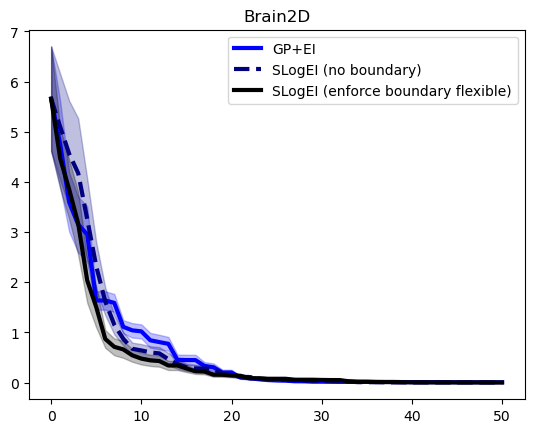

In [34]:
N = 20

total_record = (np.array(BO_EI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

total_record = (np.array(SLogEI_noboundary)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='SLogEI (no boundary)',color='red',linestyle='dashed')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='red')

total_record = (np.array(SLogEI_flexibleboundary)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='SLogEI (enforce boundary flexible)',color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')


plt.legend()
plt.title('Brain2D')

Text(0.5, 1.0, 'Beale2D')

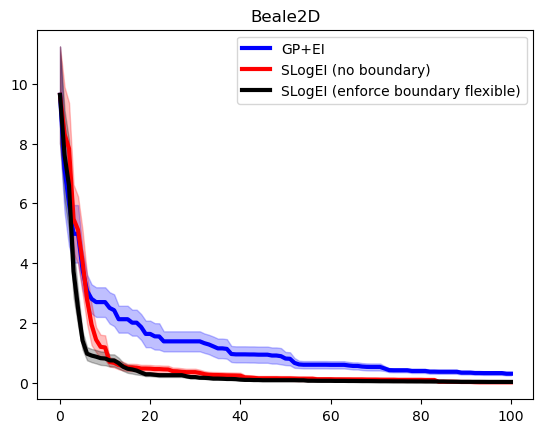

In [45]:
N = 20

total_record = (np.array(BO_EI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

total_record = (np.array(SLogEI_noboundary)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='SLogEI (no boundary)',color='red')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='red')

# total_record = np.log10(np.array(SLogEI_C1)-fstar)
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,label='SLogEI (boundary = 1.0)',color='green')
# plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='green')

# total_record = np.log10(np.array(SLogEI_enforceboundary)-fstar)
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,label='SLogEI (enforce boundary)',color='yellow')
# plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')

total_record = (np.array(SLogEI_flexibleboundary)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='SLogEI (enforce boundary flexible)',color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')


plt.legend()
plt.title('Beale2D')

Text(0.5, 1.0, 'Ackley2D')

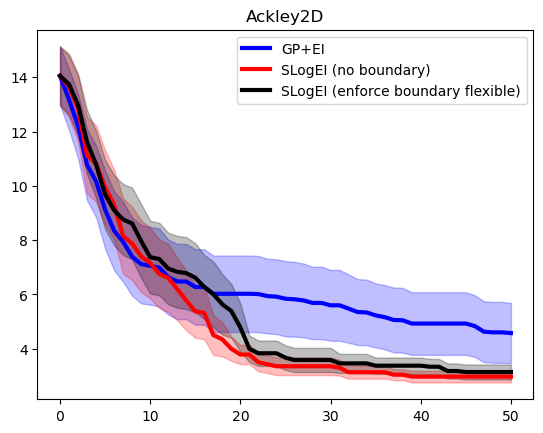

In [50]:
N = 20

total_record = (np.array(BO_EI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

total_record = (np.array(SLogEI_noboundary)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='SLogEI (no boundary)',color='red')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='red')

# total_record = np.log10(np.array(SLogEI_C1)-fstar)
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,label='SLogEI (boundary = 1.0)',color='green')
# plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='green')

# total_record = np.log10(np.array(SLogEI_enforceboundary)-fstar)
# mean = np.mean(total_record,axis=0)
# std = np.std(total_record,axis=0)
# iter = np.array(range(mean.shape[0]))
# plt.plot(mean,linewidth=3,label='SLogEI (enforce boundary)',color='yellow')
# plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')

total_record = (np.array(SLogEI_flexibleboundary)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='SLogEI (enforce boundary flexible)',color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')


plt.legend()
plt.title('Ackley2D')

In [17]:
int(4.6)

4

Text(0.5, 1.0, 'Levy2D')

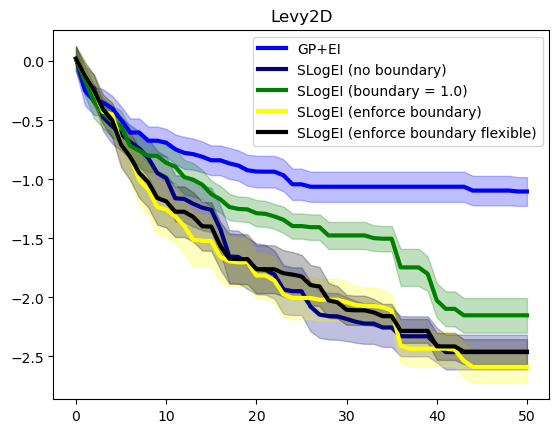

In [79]:
N = 20

total_record = np.log10(np.array(BO_EI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

total_record = np.log10(np.array(SLogEI_noboundary)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='SLogEI (no boundary)',color='navy')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='navy')

total_record = np.log10(np.array(SLogEI_C1)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='SLogEI (boundary = 1.0)',color='green')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='green')

total_record = np.log10(np.array(SLogEI_enforceboundary)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='SLogEI (enforce boundary)',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')

total_record = np.log10(np.array(SLogEI_flexibleboundary)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='SLogEI (enforce boundary flexible)',color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')


plt.legend()
plt.title('Levy2D')

Text(0.5, 1.0, 'Rosenrock2D')

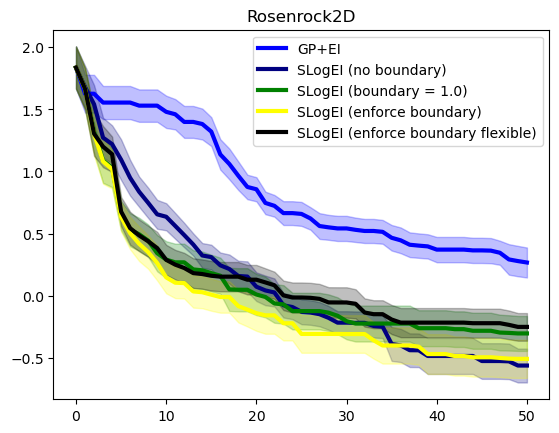

In [117]:
N = 20

fstar = 0.
total_record = np.log10(np.array(BO_EI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

total_record = np.log10(np.array(SLogEI_noboundary)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='SLogEI (no boundary)',color='navy')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='navy')

total_record = np.log10(np.array(SLogEI_C1)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='SLogEI (boundary = 1.0)',color='green')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='green')

total_record = np.log10(np.array(SLogEI_enforceboundary)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='SLogEI (enforce boundary)',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')

total_record = np.log10(np.array(SLogEI_flexibleboundary)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='SLogEI (enforce boundary flexible)',color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')


plt.legend()
plt.title('Rosenrock2D')

In [42]:
np.savetxt('exp_res/Beale2D_BO_EI', BO_EI, delimiter=',')
np.savetxt('exp_res/Beale2D_SLogEI_noboundary', SLogEI_noboundary, delimiter=',')
#np.savetxt('exp_res/Levy2D_SLogEI_C1', SLogEI_C1, delimiter=',')
#np.savetxt('exp_res/Levy2D_SLogEI_enforceboundary', SLogEI_enforceboundary, delimiter=',')
np.savetxt('exp_res/Beale2D_SLogEI_flexibleboundary', SLogEI_flexibleboundary, delimiter=',')